In [124]:
# Importing required libraries
import re
import os
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib.pyplot import figure
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from vat import VAT

In [125]:
# List all datasets and accompanying files

DATA_PATH = "/course/a2"

for root, dirs, files in os.walk(DATA_PATH):
        level = root.replace(DATA_PATH, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

a2/
    twitter/
        RPI_Expertise_2016_Features.csv
        twitter_expertise.pdf
    games/
        KRmatch.csv
        description.txt
        NAmatch.csv
        EUmatch.csv
    security/
        NUSW-NB15_features.csv
        description.txt
        UNSW_NB15_dataset.csv


In [126]:
dataEU = pd.read_csv("/course/a2/games/EUmatch.csv")
dataEU["region"] = "EU"
dataKR = pd.read_csv("/course/a2/games/KRmatch.csv")
dataKR["region"] = "KR"
dataNA = pd.read_csv("/course/a2/games/NAmatch.csv")
dataNA["region"] = "NA"
dataALL = pd.concat([dataEU, dataKR, dataNA], ignore_index=True)
dataALL = dataALL.dropna(subset = ['champion', 'side', 'level'])

# Data Preprocessing

## Impute KDA ratio, Kills, Assists, and Deaths & remove records which missing > 2 of these columns

In [127]:
# remove records with missing > 2 of the columns & impute it with the remaining data
# [K/D/A, Kills, Assists, Death]
NaN = np.NaN
def unidentified_KDA_val(row):
    row_is_null = row.isna()[["kda", "kills", "assists", "deaths"]].sum()
    if row_is_null > 1:
        return True
    return False

# predict death from damage_taken
death_predict = LinearRegression()
trainer = dataALL.dropna(subset = ["damage_taken", "deaths"])
death_predict.fit(trainer[["damage_taken"]], trainer[["deaths"]])

# formula: kda = (k+a)/d
def impute_kills(row):
    if (row.isna()["kills"] == True):
        if (row["deaths"] == 0):
            row["deaths"] = 1
        return round((row["kda"] * row["deaths"]) - row["assists"])
    return row["kills"]

def impute_assists(row):
    if (row.isna()["assists"] == True):
        if (row["deaths"] == 0):
            row["deaths"] = 1
        return round((row["kda"] * row["deaths"]) - row["kills"])
    return row["assists"]

def impute_deaths(row):
    if (row.isna()["deaths"] == True):
        if (row["kda"] == 0):
            return round(death_predict.predict(np.array(row["damage_taken"]).reshape(1, -1))[0][0])
        return round((row["kills"] + row["assists"]) / row["kda"])
    return row["deaths"]

def impute_kda(row):
    if (row.isna()["kda"] == True):
        if (row["deaths"] == 0):
            row["deaths"] = 1
        return (row["kills"] + row["assists"]) / row["deaths"]
    return row["kda"]


dataALL["is_remove"] = dataALL.apply(unidentified_KDA_val, axis=1)
dataALL = dataALL[dataALL["is_remove"] == False]
dataALL["kills"] = dataALL.apply(impute_kills, axis=1)
dataALL["assists"] = dataALL.apply(impute_assists, axis=1)
dataALL["deaths"] = dataALL.apply(impute_deaths, axis=1)
dataALL["kda"] = dataALL.apply(impute_kda, axis=1)

/usr/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Impute "damage_objective" with ["damage_turrets"]

In [128]:
dataALL['damage_objectives'].fillna(dataALL["damage_turrets"], inplace=True)
dataALL = dataALL.dropna(subset = ["damage_objectives"])

## Remove trolling jungler record by remove the champion which got pick < 0.5% of total jungler record

In [129]:
# remove TopLane_Jungle role champion which get pick < 1% of TopLane_Jungle role record
# (remove record which has a chance to be trolling jungler)

total_jungler_record = dataALL["role"].value_counts()["TopLane_Jungle"]
remove_threshold = int(total_jungler_record * 0.005)
jungler_champion_freq = dataALL[dataALL["role"] == "TopLane_Jungle"]["champion"].value_counts()
remove_list = []
for champion, freq in jungler_champion_freq.iteritems():
    if (freq < remove_threshold):
        remove_list.append(champion)
remove_set = set(remove_list)
# print("remove_threshold: {}".format(remove_threshold))
# print(len(remove_list))

def clean_trolling_jungler(row):
    if ((row["role"] == "TopLane_Jungle") & (row["champion"] in remove_set)):
        return True
    return False

dataALL["is_trolling_jungler"] = dataALL.apply(clean_trolling_jungler, axis=1)
dataALL = dataALL[dataALL["is_trolling_jungler"] == False]

## Normalize the game stat with "level" to reflect the game time behaviour

In [130]:
# normalize all game stat with level (assume that we will be able to reflect the gametime using this
# for 'Jungler' role. However, for 'Others' role which is a combination of various role(i.e. MidLaner
# , Support, and etc.), we might not be able to reflect this.)

def normalize_by_level(row, col_name):
    return row[col_name]/float(row["level"])

print(dataALL.columns)

dataALL = dataALL.drop(["is_trolling_jungler", "is_remove"], axis=1)
non_normalize_col_list = ["d_spell", "f_spell", "champion", "side", "level", "role", "minions_killed"
, "is_trolling_jungler", "region", "kda", "spell_score"]
normalize_col_list = [col for col in dataALL.columns if col not in non_normalize_col_list]
for col in normalize_col_list:
    new_col = col + "_n"
    dataALL[new_col] = dataALL.apply(normalize_by_level, args=(col,), axis=1)

Index(['d_spell', 'f_spell', 'champion', 'side', 'assists',
       'damage_objectives', 'damage_building', 'damage_turrets', 'deaths',
       'kda', 'kills', 'level', 'time_cc', 'damage_taken', 'turret_kills',
       'vision_score', 'damage_total', 'gold_earned', 'role', 'minions_killed',
       'region', 'is_remove', 'is_trolling_jungler'],
      dtype='object')


## Impute "time_cc" by means time_cc of each champion since "time_cc" will vary on game time. Thus, we need to impute with normalized data.

In [131]:
# impute time_cc from the mean from each champion
mean_time_cc_champion = round(dataALL[["champion", "time_cc_n"]].groupby("champion").mean())

def impute_time_cc(row):
    if (row.isna()["time_cc_n"] == True):
        row["time_cc_n"] = mean_time_cc_champion.loc[row["champion"]]["time_cc_n"]
    return row["time_cc_n"]

dataALL["time_cc_n"] = dataALL.apply(impute_time_cc, axis=1)

## Impute "vision_score" by mean vision_score for each champion & role

In [132]:
# impute vision_score(normalized) from the mean value from each champion & role
mean_vision_champion_role = dataALL[["champion", "role", "vision_score_n"]].groupby(["champion", "role"]).mean()

def impute_vision_score(row):
    if (row.isna()["vision_score_n"] == True):
        row["vision_score_n"] = mean_vision_champion_role.loc[row["champion"], row["role"]]["vision_score_n"]
    return row["vision_score_n"]

dataALL["vision_score_n"] = dataALL.apply(impute_vision_score, axis=1)

## Impute "damage_taken" by mean vision_score for each champion & role

In [133]:
# impute damage_taken(normalized) from the mean value from each champion & role
mean_dmgtaken_champion_role = dataALL[["champion", "role", "damage_taken_n"]].groupby(["champion", "role"]).mean()

def impute_damage_taken(row):
    if (row.isna()["damage_taken_n"] == True):
        row["damage_taken_n"] = mean_dmgtaken_champion_role.loc[row["champion"], row["role"]]["damage_taken_n"]
    return row["damage_taken_n"]

###############################################################################################
dataALL["damage_taken_n"] = dataALL.apply(impute_damage_taken, axis=1)

## Impute "damage_building" with the mean of each champion and their role

In [134]:
#creating the model to predict damage_building
mean_damage_building_champion = dataALL[["champion", "role", "damage_building_n"]].groupby(["champion", "role"]).mean()

def impute_damage_building(row):
    if (row.isna()["damage_building_n"] == True):
        row["damage_building_n"] = mean_damage_building_champion.loc[row["champion"], row["role"]]["damage_building_n"]
    return row["damage_building_n"]

###############################################################################################
dataALL["damage_building_n"] = dataALL.apply(impute_damage_building, axis=1)

## Impute "turret_kills" with the mean of each champion and their role

In [135]:
#creating the model to predict damage_building
mean_turret_kills_champion = dataALL[["champion", "role", "turret_kills_n"]].groupby(["champion", "role"]).mean()

def impute_turret_kills(row):
    if (row.isna()["turret_kills_n"] == True):
        row["turret_kills_n"] = mean_turret_kills_champion.loc[row["champion"], row["role"]]["turret_kills_n"]
    return row["turret_kills_n"]

###############################################################################################
dataALL["turret_kills_n"] = dataALL.apply(impute_turret_kills, axis=1)

## Remove Ivern which played Other roles since he has only 1 record & cannot filled in time_cc

In [136]:
dataALL = dataALL[(dataALL["champion"] != "Ivern")]
dataALL = dataALL[(dataALL["champion"] != "Quinn")]

## Rename the columns and save cleaned data as a file

In [137]:
dataALL.columns

Index(['d_spell', 'f_spell', 'champion', 'side', 'assists',
       'damage_objectives', 'damage_building', 'damage_turrets', 'deaths',
       'kda', 'kills', 'level', 'time_cc', 'damage_taken', 'turret_kills',
       'vision_score', 'damage_total', 'gold_earned', 'role', 'minions_killed',
       'region', 'assists_n', 'damage_objectives_n', 'damage_building_n',
       'damage_turrets_n', 'deaths_n', 'kills_n', 'time_cc_n',
       'damage_taken_n', 'turret_kills_n', 'vision_score_n', 'damage_total_n',
       'gold_earned_n'],
      dtype='object')

In [138]:
dataALL = dataALL.rename(columns={"assists_n": "assists_per_level",
"damage_objectives_n": "damage_obj_per_level", "damage_building_n": "damage_building_per_level",
"damage_turrets_n": "damage_turrets_per_level", "deaths_n": "deaths_per_level",
"kills_n": "kills_per_level", "time_cc_n": "time_cc_per_level", "damage_taken_n": "damage_taken_per_level",
"turret_kills_n": "turret_kills_per_level", "vision_score_n": "vision_score_per_level",
"damage_total_n": "damage_total_per_level", "gold_earned_n": "gold_earned_per_level"})
dataALL.to_csv("final_data.csv", index=False)

## Compute Data Statistic

In [0]:
def addlabels(x, y, x_size):
    for i in range(len(x)):
        plt.text(x[i] + x_size, y[i]+20, y[i], ha = 'center')


stat_data = pd.read_csv("game_data_stat.csv")
raw_stat_data = dataALL[dataALL["type"] == "raw"]
raw_stat_data = raw_stat_data.reset_index()
print(raw_stat_data)
clean_stat_data = dataALL[dataALL["type"] == "clean"]
clean_stat_data = clean_stat_data.reset_index()
print(clean_stat_data)

ind = np.arange(4)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, raw_stat_data["number"], width, color='red')
rects2 = ax.bar(ind+width, clean_stat_data["number"], width, color='green')

# add some
ax.set_ylabel('# of records')
ax.set_title('Game data record statistic (Before VS After cleaning)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('Other(RedTeam)', 'Jungle(RedTeam)', 'Other(BlueTeam)', 'Jungle(BlueTeam)') )
addlabels(ind, raw_stat_data["number"], 0)
addlabels(ind, clean_stat_data["number"], width)

ax.legend((rects1[0], rects2[0]), ('Raw Data', 'Clean Data'))
plt.savefig("data_stat.png")
plt.show()


# Visual Analysis of the correlations

## Binning

In [139]:
#binning
from sklearn.preprocessing import KBinsDiscretizer

dataALL = pd.read_csv("final_data.csv")
dataALL["binned_damage_building_n"] = pd.qcut(dataALL['damage_building_per_level'], q=10, precision=0)
dataALL["binned_damage_objectives_n"] = pd.qcut(dataALL['damage_obj_per_level'], q=5, precision=0)
dataALL["binned_damage_turrets_n"] = pd.qcut(dataALL['damage_turrets_per_level'], q=5, precision=0)
dataALL["binned_assists_n"] = pd.qcut(dataALL['assists_per_level'], q=10, precision=0)
dataALL["binned_kills_n"] = pd.qcut(dataALL['kills_per_level'], q=10, precision=0)
dataALL["binned_deaths_n"] = pd.qcut(dataALL['deaths_per_level'], q=10, precision=0)
dataALL["binned_damage_total_n"] = pd.qcut(dataALL['damage_total_per_level'], q=10, precision=0)
dataALL["binned_damage_taken_n"] = pd.qcut(dataALL['damage_taken_per_level'], q=10, precision=0)
equal_width = KBinsDiscretizer(n_bins=3, # number of bins
                               # the method and strategy which are out-of-scope for this subject. 
                               # If you are interested, take Machine Learning
                               encode='ordinal', 
                               strategy='uniform')
dataALL['binned_turret_kills'] = equal_width.fit_transform(dataALL[['turret_kills_per_level']]).astype(int)
dataALL["binned_vision_score_n"] = pd.qcut(dataALL['vision_score_per_level'], q=10, precision=0)
dataALL["binned_gold_earned_n"] = pd.qcut(dataALL['gold_earned_per_level'], q=10, precision=0)
dataALL[["minions_killed"]] = OrdinalEncoder().fit_transform(dataALL[["minions_killed"]])
dataALL[["role"]] = OrdinalEncoder().fit_transform(dataALL[["role"]])
dataALL


,d_spell,f_spell,champion,side,assists,damage_objectives,damage_building,damage_turrets,deaths,kda,...,binned_damage_objectives_n,binned_damage_turrets_n,binned_assists_n,binned_kills_n,binned_deaths_n,binned_damage_total_n,binned_damage_taken_n,binned_turret_kills,binned_vision_score_n,binned_gold_earned_n
0,14.0,4.0,Leona,Side.blue,9.0,0.0,63.0,0.0,9.0,1.111111,...,"(-1.0, 15.0]","(-1.0, 15.0]","(0.71, 0.87]","(0.083, 0.15]","(0.73, 1.57]","(491.0, 1711.0]","(1517.0, 1676.0]",0,"(4.8, 11.7]","(383.0, 588.0]"
1,1.0,4.0,Ashe,Side.red,7.0,4885.0,9190.0,4885.0,5.0,2.000000,...,"(304.0, 4221.0]","(304.0, 4221.0]","(0.42, 0.5]","(0.15, 0.21]","(0.33, 0.39]","(3572.0, 6128.0]","(1144.0, 1263.0]",0,"(1.7, 1.9]","(715.0, 752.0]"
2,4.0,11.0,Nunu,Side.red,6.0,0.0,4920.0,0.0,6.0,1.500000,...,"(-1.0, 15.0]","(-1.0, 15.0]","(0.42, 0.5]","(0.21, 0.27]","(0.45, 0.5]","(9016.0, 9918.0]","(1676.0, 1869.0]",0,"(2.3, 3.1]","(588.0, 637.0]"
3,4.0,14.0,Nautilus,Side.blue,2.0,0.0,0.0,0.0,3.0,1.000000,...,"(-1.0, 15.0]","(-1.0, 15.0]","(0.17, 0.25]","(0.083, 0.15]","(0.33, 0.39]","(1711.0, 3572.0]","(831.0, 1012.0]",0,"(2.3, 3.1]","(383.0, 588.0]"
4,4.0,14.0,Lulu,Side.red,19.0,720.0,3379.0,720.0,9.0,2.222222,...,"(15.0, 74.0]","(15.0, 74.0]","(1.14, 3.11]","(-0.01, 0.083]","(0.73, 1.57]","(491.0, 1711.0]","(1263.0, 1386.0]",0,"(4.8, 11.7]","(678.0, 715.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,14.0,4.0,Zoe,Side.red,7.0,389.0,6490.0,389.0,5.0,3.000000,...,"(15.0, 74.0]","(15.0, 74.0]","(0.42, 0.5]","(0.5, 0.61]","(0.27, 0.33]","(8135.0, 9016.0]","(1012.0, 1144.0]",0,"(1.5, 1.7]","(834.0, 884.0]"
14002,4.0,NaN,Zoe,Side.red,10.0,1825.0,1825.0,1825.0,8.0,1.500000,...,"(74.0, 161.0]","(74.0, 161.0]","(0.6, 0.71]","(0.083, 0.15]","(0.5, 0.6]","(7263.0, 8135.0]","(1012.0, 1144.0]",0,"(1.7, 1.9]","(715.0, 752.0]"
14003,14.0,4.0,Teemo,Side.blue,1.0,887.0,887.0,887.0,4.0,0.250000,...,"(74.0, 161.0]","(74.0, 161.0]","(-0.01, 0.17]","(-0.01, 0.083]","(0.39, 0.45]","(3572.0, 6128.0]","(163.0, 831.0]",0,"(-0.020000000000000004, 0.9]","(383.0, 588.0]"
14004,4.0,14.0,Thresh,Side.blue,5.0,360.0,821.0,360.0,5.0,1.200000,...,"(15.0, 74.0]","(15.0, 74.0]","(0.42, 0.5]","(0.083, 0.15]","(0.45, 0.5]","(1711.0, 3572.0]","(1263.0, 1386.0]",0,"(3.1, 4.8]","(588.0, 637.0]"


## Feature MI Correlation (HeatMaps)

/usr/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and unknown values for target
  warnings.warn(msg, UserWarning)
/usr/lib/python3.10/site-packages/sklea

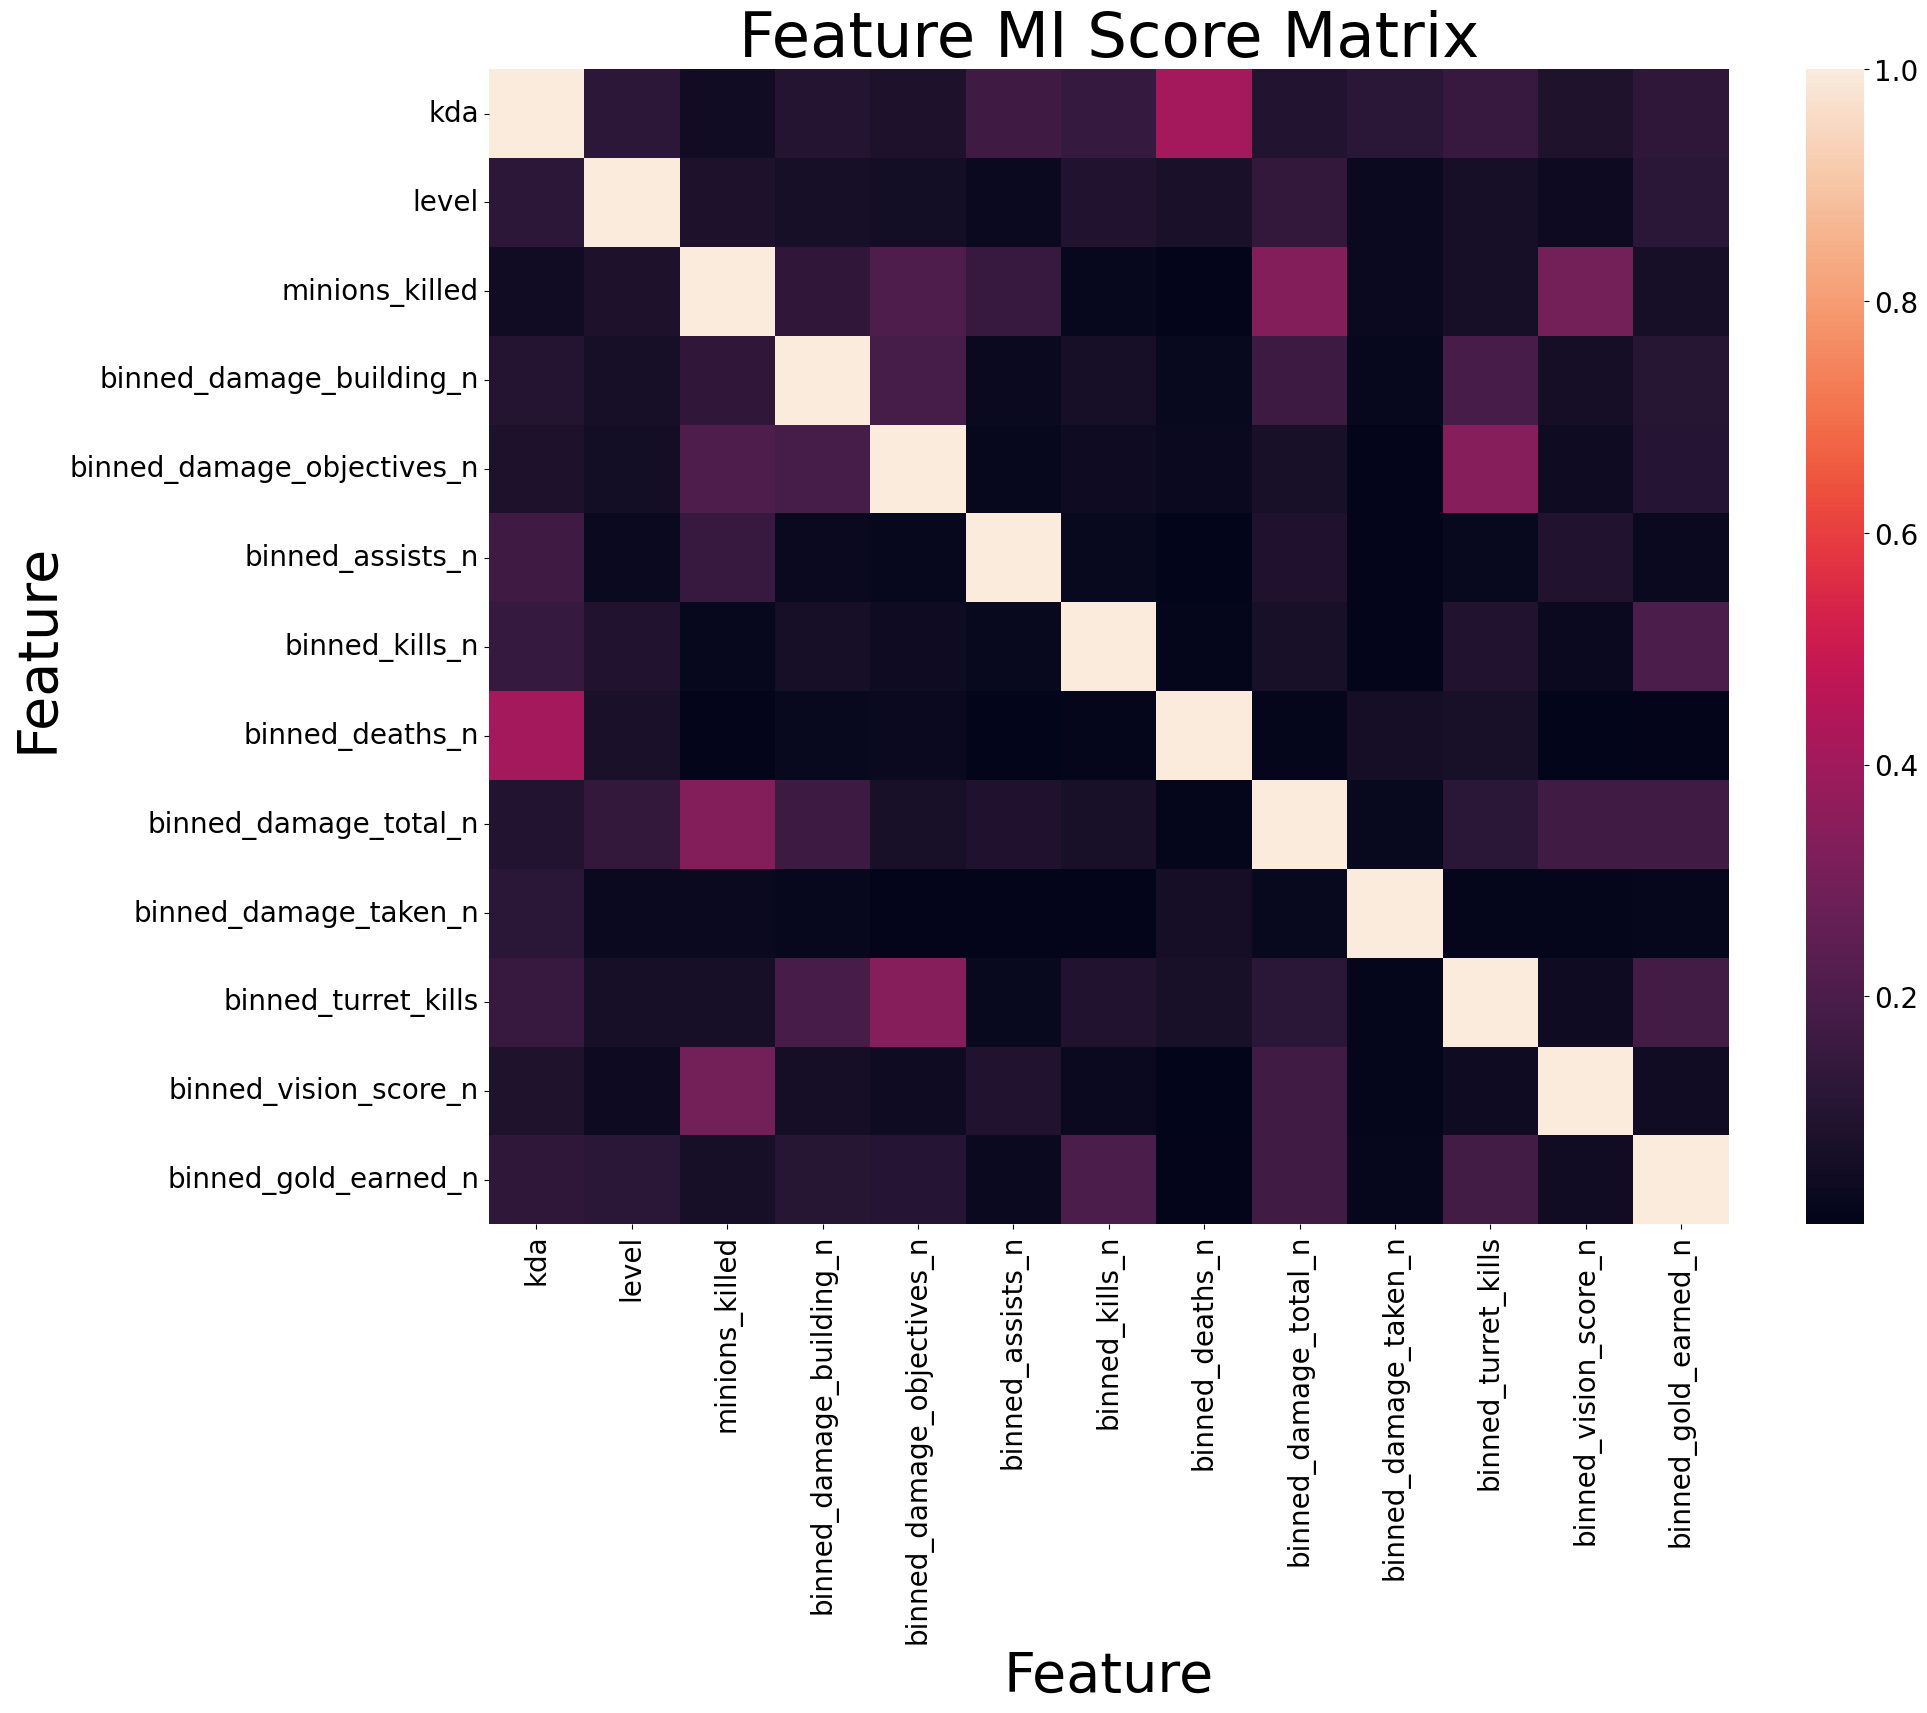

In [140]:
MI_data = dataALL[['kda', 'level', 'minions_killed',
       'binned_damage_building_n', 'binned_damage_objectives_n',
       'binned_assists_n', 'binned_kills_n', 'binned_deaths_n',
       'binned_damage_total_n', 'binned_damage_taken_n', 'binned_turret_kills',
       'binned_vision_score_n', 'binned_gold_earned_n']]
MI_df = pd.DataFrame(columns=MI_data.columns)
i = 0

matplotlib.rcParams.update({'font.size': 20})

for col1 in MI_data.columns:
    MI_list = []
    for col2 in MI_data.columns:
        # print("col1: {}".format(col1))
        # print("col2: {}".format(col2))
        score = normalized_mutual_info_score(MI_data[col1], 
                             MI_data[col2], 
                             average_method='min')
        MI_list.append(score)
    MI_df.loc[col1] = MI_list
fig = plt.figure(figsize = (20, 15))
heat_map = sns.heatmap(MI_df)
# Add title and axis names
plt.xlabel("Feature", fontsize=40)
plt.ylabel("Feature", fontsize=40)
plt.title("Feature MI Score Matrix", fontsize=45)
plt.savefig('MI_score')

## Feature MI Distribution 

In [141]:
final_MI_list = []
for index, row in MI_df.iterrows():
    for val in row:
        final_MI_list.append(val)
final_MI_size = len(final_MI_list)
final_MI_list = sorted(final_MI_list)
print(final_MI_list)

[0.0032863656167777455, 0.0032863656167777455, 0.0071761160146367985, 0.0071761160146367985, 0.0076931014860422125, 0.0076931014860422125, 0.00839627888894452, 0.00839627888894452, 0.008898566491796506, 0.008898566491796506, 0.009712465520180466, 0.009712465520180468, 0.009943527406171368, 0.009943527406171368, 0.011269179567450145, 0.011269179567450147, 0.013387075939709841, 0.013387075939709846, 0.01388329029875083, 0.013883290298750833, 0.014571148707277708, 0.014571148707277708, 0.015862123544605193, 0.015862123544605193, 0.019089328870660855, 0.019089328870660855, 0.021627590262344808, 0.021627590262344808, 0.022504794091195823, 0.022504794091195823, 0.024362082860139578, 0.02436208286013958, 0.024673208182907292, 0.024673208182907292, 0.025236240950878258, 0.025236240950878258, 0.026564766557520787, 0.026564766557520787, 0.028854516056839447, 0.028854516056839447, 0.029923757464606376, 0.029923757464606376, 0.030224599040949606, 0.030224599040949606, 0.03190080404286277, 0.031900

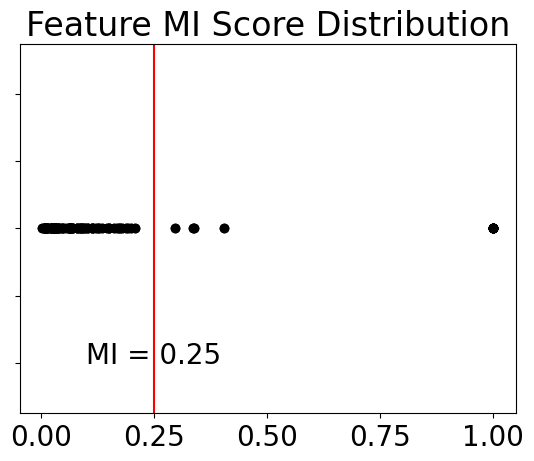

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(final_MI_list, [0]*final_MI_size, 'o', color='black')
ax.set_yticklabels([])
ax.set_title('Feature MI Score Distribution', )
ax.axvline(0.25, color="red")
ax.text(0.25, -0.04, "MI = 0.25", ha='center')
# ax.set_xlim(0, 0.25)
plt.savefig("feature_MI_distribution.png")
plt.show()

## Feature MI Distribution (filtered feature pairs which has value > MI threshold (0.25))

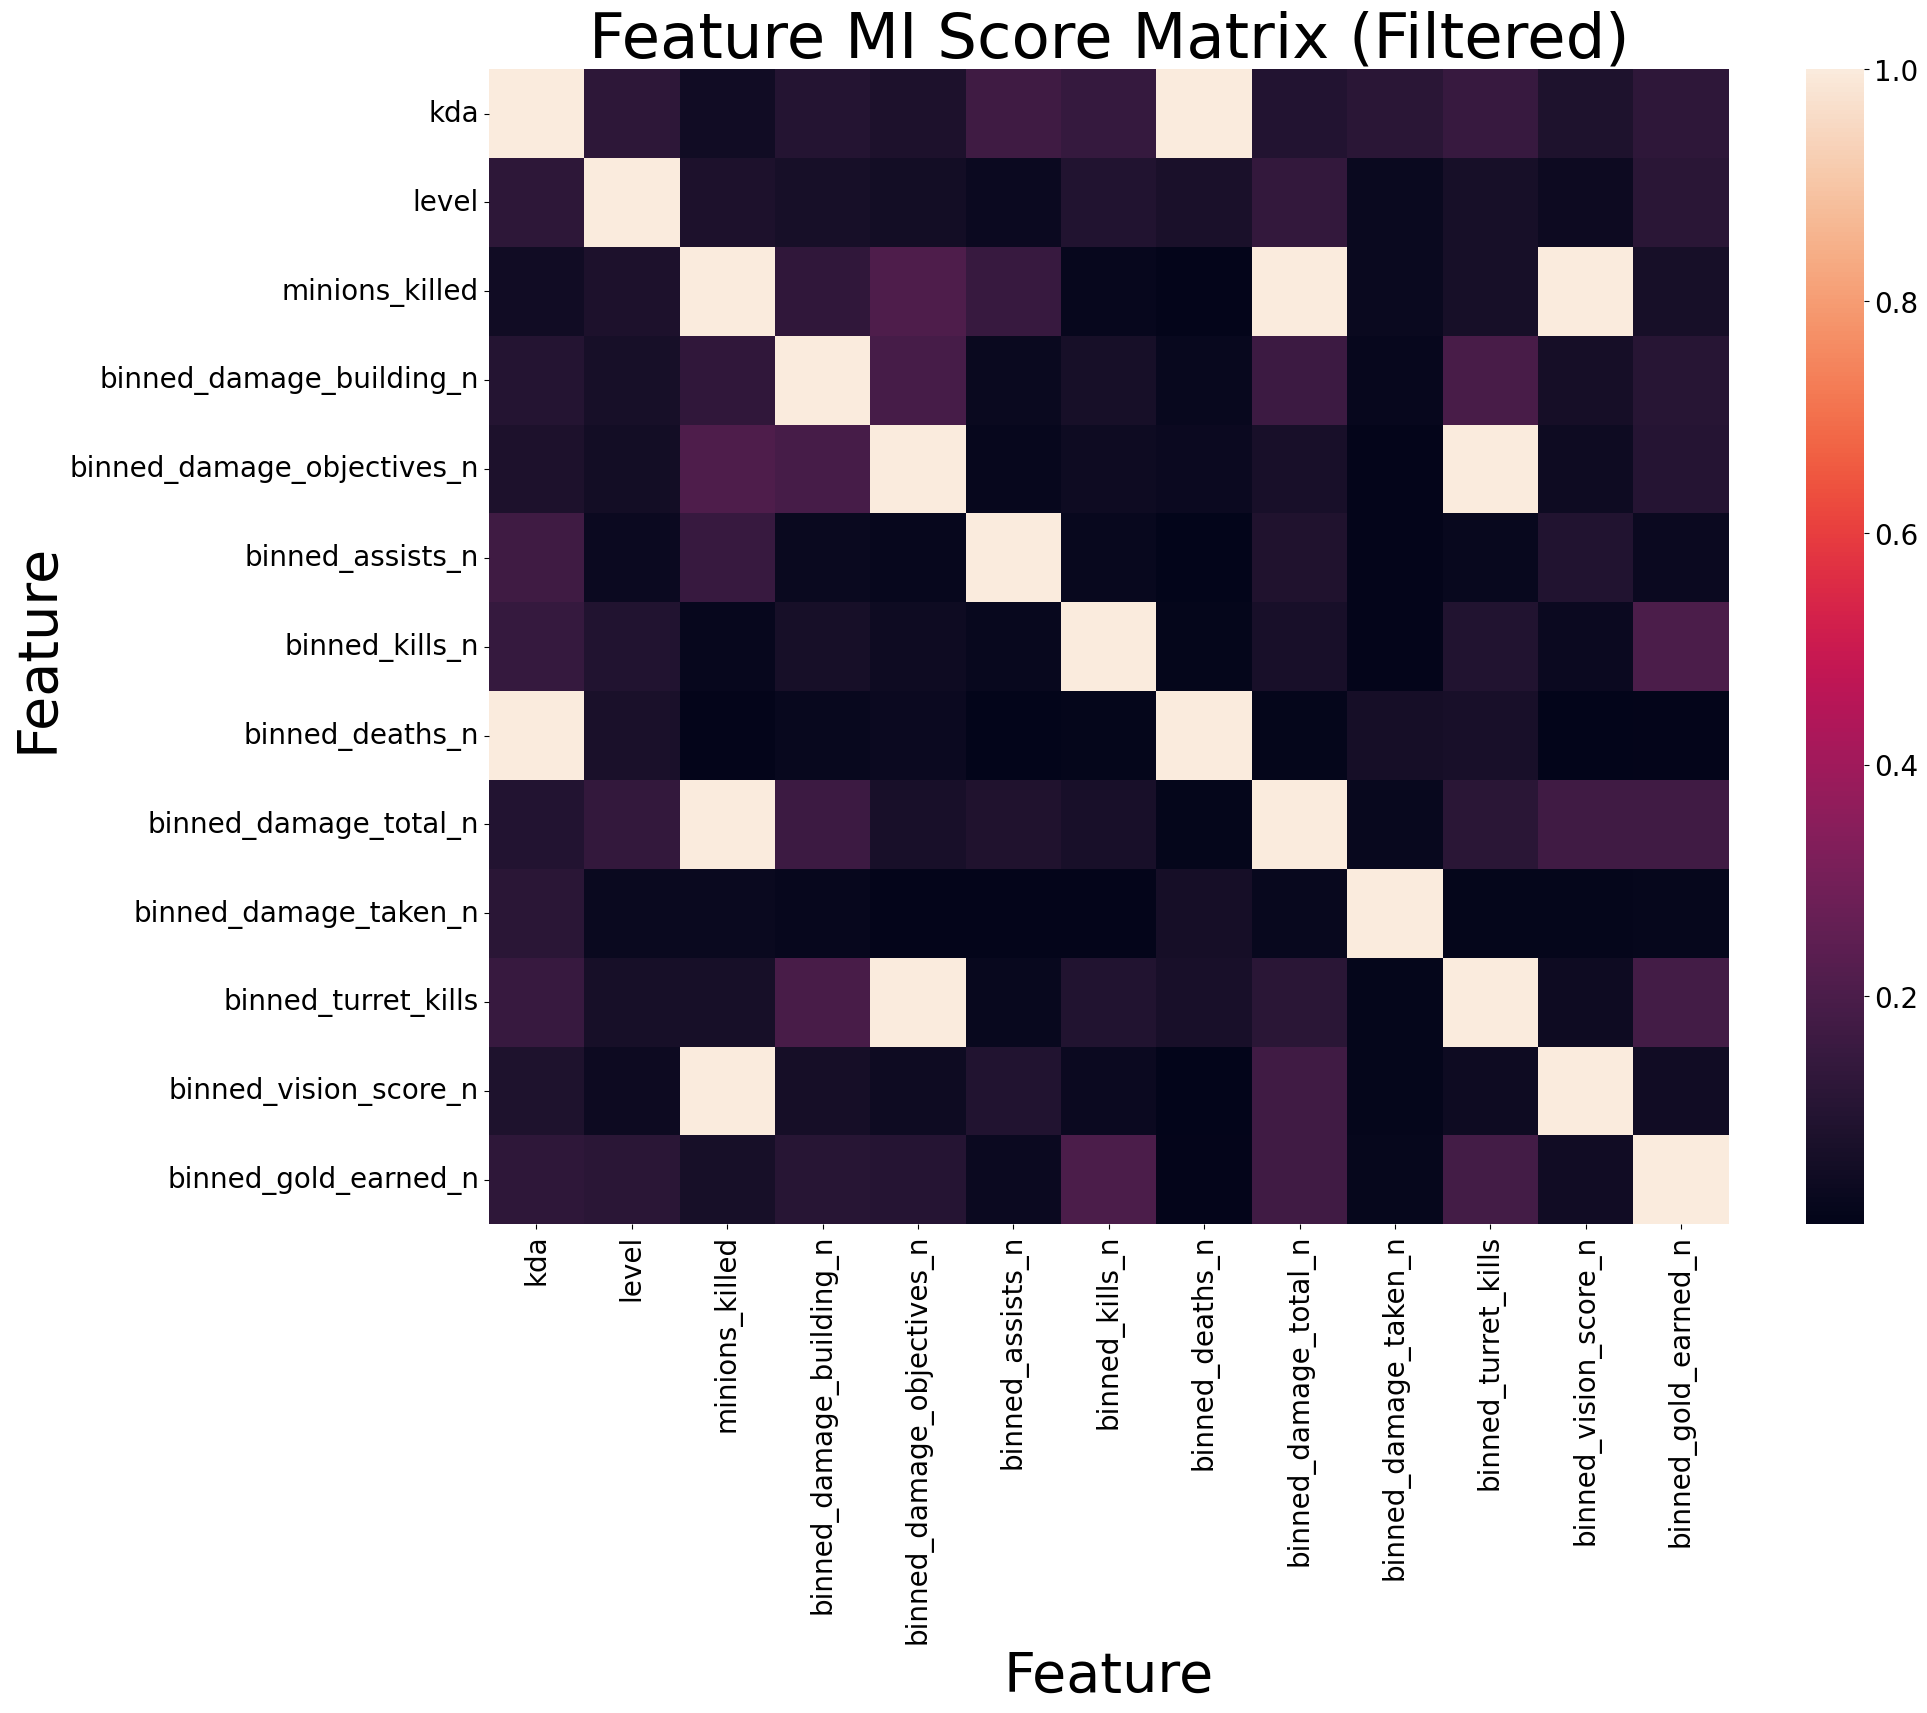

In [143]:
def get_rid(x):
    if x > 0.25:
        return 1
    return x

MI_df_remove = MI_df.applymap(get_rid)
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (20, 15))
heat_map = sns.heatmap(MI_df_remove)
# Add title and axis names
plt.xlabel("Feature", fontsize=40)
plt.ylabel("Feature", fontsize=40)
plt.title("Feature MI Score Matrix (Filtered)", fontsize=45)
plt.savefig('MI_score_clean')

# Future Selection

## PCA

In [144]:
dataALL.columns

Index(['d_spell', 'f_spell', 'champion', 'side', 'assists',
       'damage_objectives', 'damage_building', 'damage_turrets', 'deaths',
       'kda', 'kills', 'level', 'time_cc', 'damage_taken', 'turret_kills',
       'vision_score', 'damage_total', 'gold_earned', 'role', 'minions_killed',
       'region', 'assists_per_level', 'damage_obj_per_level',
       'damage_building_per_level', 'damage_turrets_per_level',
       'deaths_per_level', 'kills_per_level', 'time_cc_per_level',
       'damage_taken_per_level', 'turret_kills_per_level',
       'vision_score_per_level', 'damage_total_per_level',
       'gold_earned_per_level', 'binned_damage_building_n',
       'binned_damage_objectives_n', 'binned_damage_turrets_n',
       'binned_assists_n', 'binned_kills_n', 'binned_deaths_n',
       'binned_damage_total_n', 'binned_damage_taken_n', 'binned_turret_kills',
       'binned_vision_score_n', 'binned_gold_earned_n'],
      dtype='object')

In [145]:
dataALL = pd.read_csv("final_data.csv")
pca_data = dataALL[['kda', 'level', 'damage_building_per_level', 'damage_obj_per_level',
'assists_per_level', 'kills_per_level', 'damage_total_per_level', 'damage_taken_per_level',
'vision_score_per_level', 'gold_earned_per_level']]
normalized_cluster_data = MinMaxScaler().fit_transform(pca_data)
normalized_data_df = pd.DataFrame(normalized_cluster_data)
normalized_data_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000
mean,0.106234,0.630402,0.131938,0.042622,0.188449,0.216336,0.239549,0.277698,0.186606,0.316479
std,0.112294,0.202960,0.137408,0.051559,0.129231,0.151759,0.129560,0.114481,0.138962,0.121194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038095,0.500000,0.030790,0.006761,0.096429,0.101010,0.158915,0.197655,0.097636,0.227753
50%,0.068571,0.666667,0.083429,0.026739,0.160714,0.185185,0.250950,0.262981,0.138904,0.305749
75%,0.128571,0.750000,0.189228,0.061974,0.250000,0.307239,0.325805,0.344834,0.212557,0.393061
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [146]:
# conduct PCA with n=3 components (or axis)
sklearn_pca = PCA(n_components=3)
X_pca = sklearn_pca.fit_transform(normalized_data_df)

explained_var_all = sklearn_pca.explained_variance_ratio_

print(f"Variance explained by each PC: {explained_var_all}")   
print(f"Total variance explained: {explained_var_all.sum():.4f}")
pca_df = (pd.DataFrame(sklearn_pca.components_,columns=pca_data.columns,index = ['PC-1','PC-2','PC-3']))

pca_variance_df = pd.DataFrame(sklearn_pca.components_,columns=pca_data.columns,index = ['PC-1','PC-2','PC-3'])
pca_variance_df.loc['PC-1'] = pca_variance_df.loc['PC-1'] * explained_var_all[0]
pca_variance_df.loc['PC-2'] = pca_variance_df.loc['PC-2'] * explained_var_all[1]
pca_variance_df.loc['PC-3'] = pca_variance_df.loc['PC-3'] * explained_var_all[2]
print(pca_variance_df)

Variance explained by each PC: [0.44471391 0.17662808 0.12461014]
Total variance explained: 0.7460
           kda     level  damage_building_per_level  damage_obj_per_level  \
PC-1  0.040776  0.266587                   0.146563              0.035223   
PC-2  0.039333  0.065751                  -0.003488             -0.003299   
PC-3  0.060517 -0.063898                   0.028508              0.009136   

      assists_per_level  kills_per_level  damage_total_per_level  \
PC-1          -0.038453         0.172828                0.179008   
PC-2           0.110360        -0.004024               -0.036377   
PC-3           0.015128         0.067629               -0.011647   

      damage_taken_per_level  vision_score_per_level  gold_earned_per_level  
PC-1                0.069866               -0.084699               0.163923  
PC-2                0.005842                0.107918               0.010239  
PC-3               -0.037668                0.001059               0.022977  


In [147]:
print(pca_variance_df.apply(max, axis=0))
# level, damage_total_n, kills_n, gold_earned_n, damage_building_n, assists_n

feature_weight = []
for index, row in pca_variance_df.iterrows():
    for val in row:
        feature_weight.append(abs(val))
feature_weight_size = len(feature_weight)
feature_weight = sorted(feature_weight)
print(feature_weight)

kda                          0.060517
level                        0.266587
damage_building_per_level    0.146563
damage_obj_per_level         0.035223
assists_per_level            0.110360
kills_per_level              0.172828
damage_total_per_level       0.179008
damage_taken_per_level       0.069866
vision_score_per_level       0.107918
gold_earned_per_level        0.163923
dtype: float64
[0.0010593649933214034, 0.0032990189691416063, 0.0034876664910948284, 0.0040242541247465504, 0.005841600610269923, 0.009136402444766566, 0.010239395508028078, 0.011647044764747276, 0.015128038990687456, 0.022976996813182327, 0.028508233862634572, 0.03522251390052211, 0.03637736415501658, 0.03766849704563277, 0.03845284043793213, 0.03933276816932829, 0.040775748750714255, 0.060517289978248776, 0.06389765523789342, 0.06575136383898793, 0.06762949275488704, 0.06986592821902415, 0.08469901084796481, 0.10791794885220538, 0.11036014354962567, 0.1465631366711572, 0.1639226039535154, 0.17282775718785418, 0

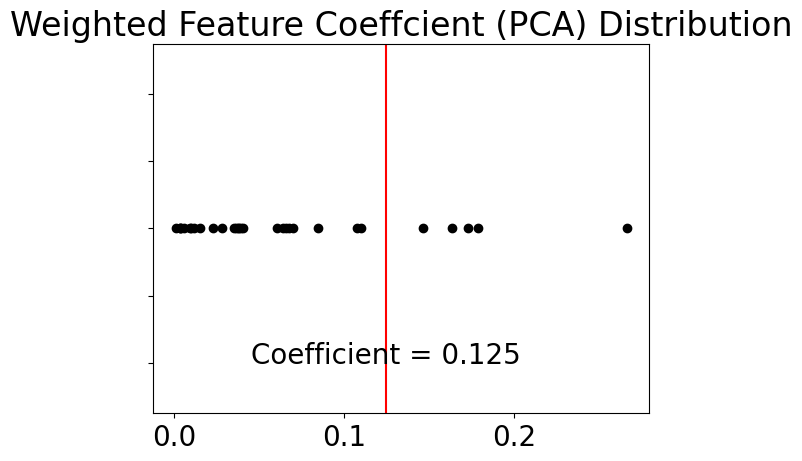

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(feature_weight, [0]*feature_weight_size, 'o', color='black')
ax.set_yticklabels([])
ax.set_title('Weighted Feature Coeffcient (PCA) Distribution')
ax.axvline(0.125, color="red")
ax.text(0.125, -0.04, "Coefficient = 0.125", ha='center')
plt.savefig("weigthed_feature_coeff.png")
plt.show()

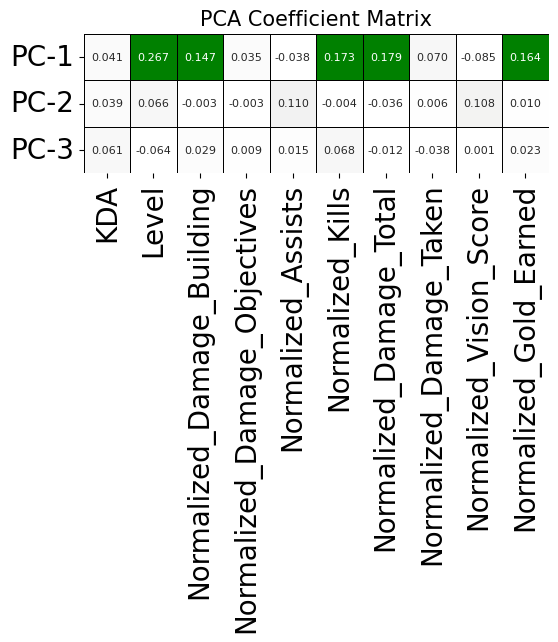

In [149]:
pca_table_df = pca_variance_df.rename(columns={"kda": "KDA", "level": "Level", 
"damage_building_per_level": "Normalized_Damage_Building",
"damage_obj_per_level": "Normalized_Damage_Objectives",
"assists_per_level": "Normalized_Assists", "kills_per_level": "Normalized_Kills", 
"damage_total_per_level": "Normalized_Damage_Total", "damage_taken_per_level": "Normalized_Damage_Taken",
"vision_score_per_level": "Normalized_Vision_Score", "gold_earned_per_level": "Normalized_Gold_Earned"})
pca_table_df = round(pca_table_df, 3)

fig, ax = plt.subplots()
white = sns.light_palette("white", reverse=True, as_cmap=True)
white.set_over('green')
sns.heatmap(pca_table_df, annot=True, annot_kws={"size":8}, fmt='.3f', square=True,
            cmap=white, vmin=0, vmax=0.125, cbar=False, ax=ax, linewidths=0.5, linecolor='black')
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.figure.set_size_inches(6, 6)
plt.title("PCA Coefficient Matrix", fontsize=15)
plt.savefig("PCA_Coeff_table.png")
plt.show()

## VAT & Elbow Method

In [150]:
normalized_data_df.columns = ['kda', 'level', 'norm_damage_building_per_level',
'norm_damage_obj_per_level', 'norm_assists_per_level', 'norm_kills_per_level',
'norm_damage_total_per_level', 'norm_damage_taken_per_level', 'norm_vision_score_per_level',
'norm_gold_earned_per_level']
normalized_data_df

,kda,level,norm_damage_building_per_level,norm_damage_obj_per_level,norm_assists_per_level,norm_kills_per_level,norm_damage_total_per_level,norm_damage_taken_per_level,norm_vision_score_per_level,norm_gold_earned_per_level
0,0.031746,0.416667,0.001202,0.000000,0.262987,0.050505,0.025041,0.314506,0.455853,0.128875
1,0.057143,0.666667,0.137748,0.082662,0.160714,0.119048,0.181504,0.228354,0.140802,0.284304
2,0.042857,0.500000,0.086036,0.000000,0.160714,0.138889,0.284571,0.361771,0.201439,0.204934
3,0.028571,0.166667,0.000000,0.000000,0.080357,0.069444,0.057115,0.144436,0.208633,0.135329
4,0.063492,0.500000,0.059089,0.014214,0.508929,0.046296,0.034306,0.246520,0.417266,0.244431
...,...,...,...,...,...,...,...,...,...,...
14001,0.085714,0.750000,0.090793,0.006144,0.150000,0.296296,0.257396,0.210576,0.131967,0.375699
14002,0.042857,0.750000,0.025531,0.028823,0.214286,0.074074,0.237480,0.199597,0.148201,0.285119
14003,0.007143,0.333333,0.018613,0.021013,0.032143,0.000000,0.129794,0.111157,0.053237,0.065627
14004,0.034286,0.333333,0.017228,0.008528,0.160714,0.055556,0.047232,0.250535,0.346763,0.174805


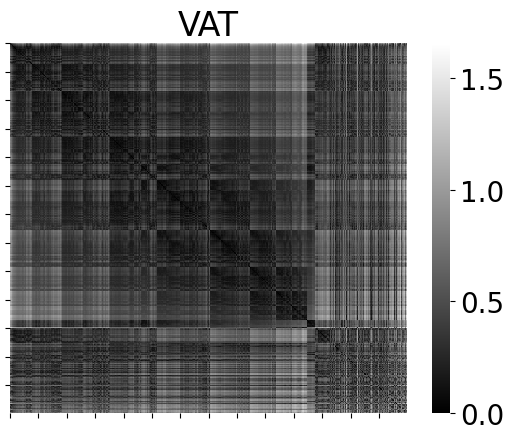

In [151]:
#VAT approach
# new feature: level, spell_score, damage_building_n, damage_total_n, gold_earned_n
# VAT_data = normalized_data_df[["level", "damage_total_n", "gold_earned_n", "kills_n", "damage_building_n"]]
VAT_data = normalized_data_df[["level", "norm_damage_total_per_level", "norm_gold_earned_per_level",
"norm_kills_per_level", "norm_damage_building_per_level"]]
RV, _, I = VAT(VAT_data[:2000]) # I are the reordered indices
fig,ax = plt.subplots(1)
sns.heatmap(RV, cmap='gray')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("VAT")
plt.savefig("VAT_sample.png")
plt.show()

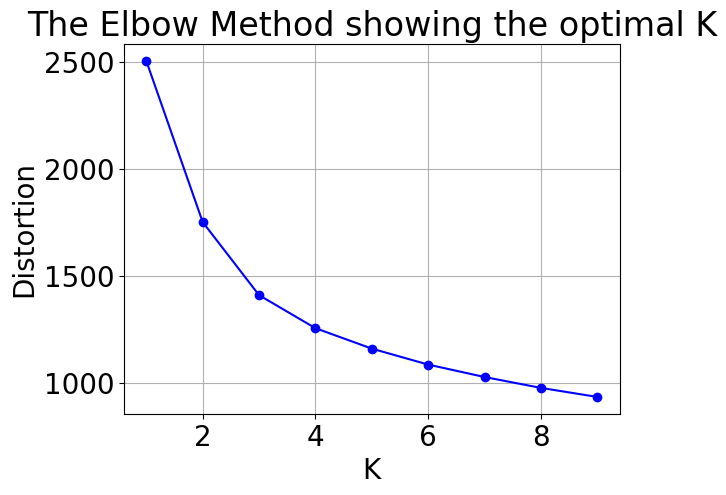

In [152]:
# elbow method approach
cluster_data = normalized_data_df[["level", "norm_damage_total_per_level", "norm_gold_earned_per_level",
"norm_kills_per_level", "norm_damage_building_per_level"]]
distortions = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_cluster_data)
    distortions.append(kmeans.inertia_) # Question: What does kmeans.inertia_ return? 

plt.plot(k_range, distortions, 'bo-')
plt.title('The Elbow Method showing the optimal K')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.grid()
plt.savefig("elbow_method2.png")
plt.show()

## K-Means Clustering (K=3)

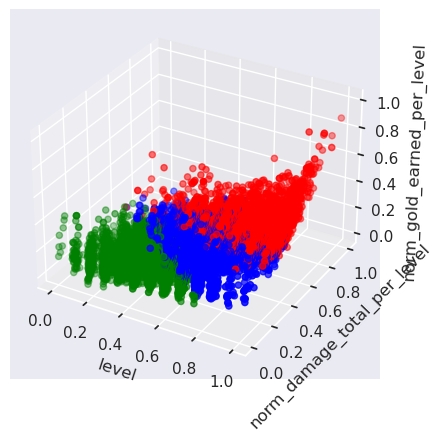

In [153]:
clusters = KMeans(n_clusters=3)
cluster_data = normalized_data_df[["level", "norm_damage_total_per_level", "norm_gold_earned_per_level",
"norm_kills_per_level", "norm_damage_building_per_level"]]
clusters.fit(cluster_data)

def plot_kmeans(df, clusters):
    """
    generate a 3d plot given sklearn's kmeans implementation 
    """
    sns.set(style = "darkgrid")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    colormap = {0: 'red', 1: 'green', 2: 'blue', 3: 'black', 4:'yellow'}

    x = df['level']
    y = df['norm_damage_total_per_level']
    z = df['norm_gold_earned_per_level']

    ax.set_xlabel("level")
    ax.set_ylabel("norm_damage_total_per_level")
    ax.set_zlabel("norm_gold_earned_per_level")

    ax.scatter(x, y, z, c=[colormap.get(x) for x in clusters.labels_])

    plt.show()

## sample cluster with some features plot
plot_kmeans(cluster_data, clusters)

In [154]:
cluster_data["clusters"] = clusters.predict(cluster_data)

/tmp/ipykernel_169/1739065589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["clusters"] = clusters.predict(cluster_data)


In [155]:
cluster_data

,level,norm_damage_total_per_level,norm_gold_earned_per_level,norm_kills_per_level,norm_damage_building_per_level,clusters
0,0.416667,0.025041,0.128875,0.050505,0.001202,1
1,0.666667,0.181504,0.284304,0.119048,0.137748,2
2,0.500000,0.284571,0.204934,0.138889,0.086036,1
3,0.166667,0.057115,0.135329,0.069444,0.000000,1
4,0.500000,0.034306,0.244431,0.046296,0.059089,1
...,...,...,...,...,...,...
14001,0.750000,0.257396,0.375699,0.296296,0.090793,2
14002,0.750000,0.237480,0.285119,0.074074,0.025531,2
14003,0.333333,0.129794,0.065627,0.000000,0.018613,1
14004,0.333333,0.047232,0.174805,0.055556,0.017228,1


## Feature Scatter Plot Matrix


In [156]:
scp_matrix_data = cluster_data
scp_matrix_data = scp_matrix_data.rename(columns={"level": "Level",
"norm_damage_total_per_level": "Normalized_Damage_Total", 
"norm_gold_earned_per_level": "Normalized_Gold_Earned", "norm_kills_per_level": "Normalized_Kills",
"norm_damage_building_per_level": "Normalized_Damage_Building", "clusters": "Cluster"})
scp_matrix_data["Cluster"] = scp_matrix_data["Cluster"].astype(str)
fig = px.scatter_matrix(scp_matrix_data,
    dimensions=["Level", "Normalized_Damage_Total", "Normalized_Gold_Earned", "Normalized_Kills",
    "Normalized_Damage_Building"],
    color="Cluster",
    title="Importance Feature Scatter Matrix of Game(LOL) Dataset",
    width=3500, height=3500)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    font=dict(
        size=30
    )
)
fig.show()

/usr/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [157]:
# This cluster number will randomly changed, everytime we re-run the K-Means
# Thus, we also need to change the 'cluster_label'
dataALL["cluster"] = cluster_data["clusters"]

def apply_cluster_label(col):
    if col == 0:
        return "Moderate Performer"
    elif col == 1:
        return "Worst Performer"
    else:
        return "Best Performer"


dataALL["cluster_label"] = dataALL["cluster"].apply(apply_cluster_label)

## plot relationship between side & cluster separated role

In [158]:
jungler_data = dataALL[dataALL["role"] == "TopLane_Jungle"]
others_data = dataALL[dataALL["role"] == "Other"]
jungler_data_red = jungler_data[jungler_data["side"] == "Side.red"]
jungler_data_blue = jungler_data[jungler_data["side"] == "Side.blue"]
others_data_red = others_data[others_data["side"] == "Side.red"]
others_data_blue = others_data[others_data["side"] == "Side.blue"]

Worst Performer      -0.59
Moderate Performer   -2.62
Best Performer        3.21
Name: cluster_label, dtype: float64
Worst Performer      -1.42
Moderate Performer    1.62
Best Performer       -0.20
Name: cluster_label, dtype: float64


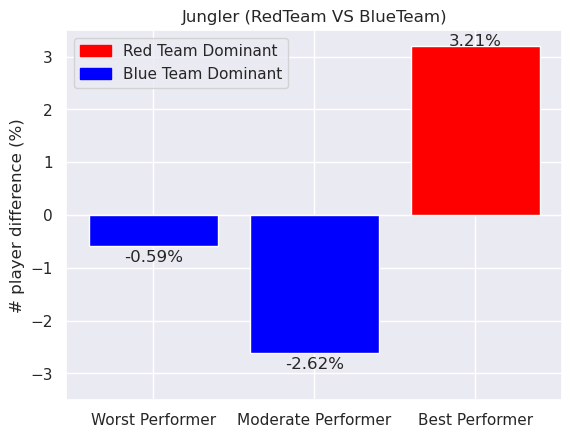

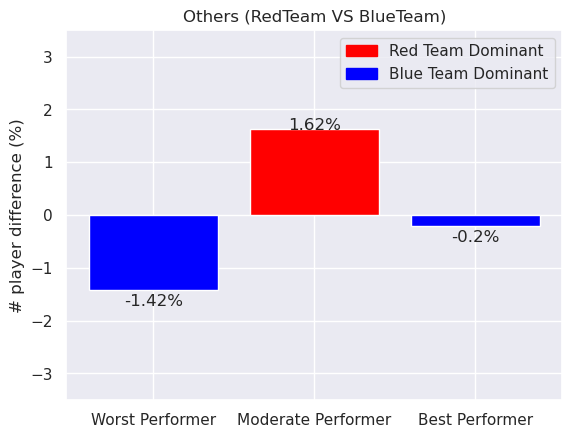

In [159]:
import matplotlib.patches as mpatches

def addlabels(x, y):
    for i in range(len(x)):
        if (y[i] >= 0):
            plt.text(x[i], y[i], str(round(y[i], 2)) + "%", ha = 'center')
        else:
            plt.text(x[i], y[i]-0.3, str(round(y[i], 2)) + "%", ha = 'center')

def plot_bar(df1, df2, plt_name):
    red_df = cal_stat(df1)
    blue_df = cal_stat(df2)
    final_df = red_df - blue_df
    final_df = final_df.sort_index(ascending=False)
    print(final_df)
    color = []
    for index, val in final_df.iteritems():
        if (val >= 0):
            color.append('red')
        else:
            color.append('blue')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(final_df.index, final_df, color=color)
    ax.set_title(plt_name)
    ax.set_ylabel("# player difference (%)")
    ax.set_ylim(-3.5, 3.5)
    addlabels(final_df.index, final_df)
    red_patch = mpatches.Patch(color='red', label='Red Team Dominant')
    blue_patch = mpatches.Patch(color='blue', label='Blue Team Dominant')
    plt.legend(handles=[red_patch, blue_patch])
    plt.savefig(plt_name + ".png")
    plt.show()

def cal_stat(df):
    total = len(df)
    cal_df = df["cluster_label"].value_counts()
    cal_df = round(cal_df * 100 / total, 2)
    return cal_df

plot_bar(jungler_data_red, jungler_data_blue, "Jungler (RedTeam VS BlueTeam)")
# plot_bar(jungler_data_blue)
plot_bar(others_data_red, others_data_blue, "Others (RedTeam VS BlueTeam)")
# plot_bar(others_data_blue)